<a href="https://colab.research.google.com/github/Rizzshen/AiGoogleCollab/blob/main/2462270_RishenManandhar_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Air Quality Classification: Predicting City Type from Pollution Data

**Course:** 5CS037 - Concepts and Technologies of AI  
**Student:** Rishen Manandhar
**ID:** 2462270



## 1. Introduction

**Problem:** Classify cities as Industrial or Residential based on air quality measurements.

**Dataset:** City Air Quality Dataset
- 52,704 hourly observations from 6 cities (Moscow, Delhi, Beijing, London, New York, Tokyo)
- 6 pollutant features: CO, NO2, SO2, O3, PM2.5, PM10
- Target: Industrial vs Residential

**UN SDG Alignment:** Supports UN SDG 11 (Sustainable Cities) by enabling better air quality monitoring and policy decisions.

**Objective:**
1. Build a Neural Network classifier
2. Build two Classical ML models (Logistic Regression & Random Forest)
3. Optimize using hyperparameter tuning
4. Apply feature selection (RFE)
5. Compare all models

In [75]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##1. Data Loading

In [76]:
df = pd.read_csv('/content/drive/MyDrive/datasets/City_Types.csv',encoding='latin-1')

print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst 5 rows:")
df.head()

Shape: 52704 rows × 9 columns

Columns: ['Date', 'City', 'CO', 'NO2', 'SO2', 'O3', 'PM2.5', 'PM10', 'Type']

First 5 rows:


,Date,City,CO,NO2,SO2,O3,PM2.5,PM10,Type
0,2024-01-01 00:00:00+00:00,Moscow,208.0,15.9,13.2,44.0,8.6,9.4,Industrial
1,2024-01-01 01:00:00+00:00,Moscow,207.0,17.4,13.7,44.0,8.6,10.5,Industrial
2,2024-01-01 02:00:00+00:00,Moscow,217.0,19.0,15.5,43.0,10.4,12.9,Industrial
3,2024-01-01 03:00:00+00:00,Moscow,231.0,21.0,20.7,36.0,12.3,15.3,Industrial
4,2024-01-01 04:00:00+00:00,Moscow,263.0,34.5,27.2,27.0,13.6,20.0,Industrial


## Dataset Description

- **Total Rows:** 52,704 hourly observations
- **Total Columns:** 9 features
- **Each row represents:** One hour of air quality measurements from a specific city

The dataset contains time-series pollution data spanning full year 2024 across 6 global cities.

In [77]:
attr = pd.DataFrame({
    'Feature': ['Date', 'City', 'CO', 'NO2', 'SO2', 'O3', 'PM2.5', 'PM10', 'Type'],
    'Type': ['DateTime', 'Categorical', 'Numerical', 'Numerical', 'Numerical',
             'Numerical', 'Numerical', 'Numerical', 'Target'],
    'Use': ['Remove', 'Remove (Leakage)', 'Keep', 'Keep', 'Keep', 'Keep', 'Keep', 'Keep', 'Predict']
})
print(attr.to_string(index=False))

Feature        Type              Use
   Date    DateTime           Remove
   City Categorical Remove (Leakage)
     CO   Numerical             Keep
    NO2   Numerical             Keep
    SO2   Numerical             Keep
     O3   Numerical             Keep
  PM2.5   Numerical             Keep
   PM10   Numerical             Keep
   Type      Target          Predict


**Target Variable**


In [78]:
print(df['Type'].value_counts())
print(f"\nClasses: Industrial (Moscow, Delhi, Beijing) vs Residential (Zurich, Vancouver, Stockholm)")

Type
Industrial     26352
Residential    26352
Name: count, dtype: int64

Classes: Industrial (Moscow, Delhi, Beijing) vs Residential (Zurich, Vancouver, Stockholm)


##2. DATA CLEANING


In [79]:
# Check missing values
print("\n1. MISSING VALUES:")
missing = df.isnull().sum()
print(missing)
print(f"\nTotal missing: {missing.sum()}")

# Check duplicates
print(f"\n2. DUPLICATES: {df.duplicated().sum()}")

# Check unique values
print(f"\n3. UNIQUE VALUES PER COLUMN:")
for col in df.columns:
    print(f"   {col}: {df[col].nunique()} unique values")


1. MISSING VALUES:
Date     0
City     0
CO       0
NO2      0
SO2      0
O3       0
PM2.5    0
PM10     0
Type     0
dtype: int64

Total missing: 0

2. DUPLICATES: 0

3. UNIQUE VALUES PER COLUMN:
   Date: 8784 unique values
   City: 6 unique values
   CO: 3200 unique values
   NO2: 1392 unique values
   SO2: 1988 unique values
   O3: 302 unique values
   PM2.5: 1407 unique values
   PM10: 1654 unique values
   Type: 2 unique values


###Cleaned the Duplicate Data


In [80]:
df = df.drop_duplicates()


### Dataset Quality Assessment

In [81]:
# Check class balance
print("\n4. CLASS BALANCE ASSESSMENT:")
print(df['Type'].value_counts())
balance_ratio = df['Type'].value_counts().min() / df['Type'].value_counts().max()
print(f"\nBalance ratio: {balance_ratio:.2%}")

if balance_ratio >= 0.9:
    print("✓ Dataset is well-balanced - no class imbalance issues")
elif balance_ratio >= 0.7:
    print("⚠ Slight imbalance - acceptable for most models")
else:
    print("✗ Significant imbalance - may require special handling")

print("\n5. DATASET QUALITY SUMMARY:")
print(f"✓ No missing values")
print(f"✓ No duplicates")
print(f"✓ Balanced classes ({balance_ratio:.2%})")
print(f"✓ Sufficient data: {df.shape[0]:,} samples")


4. CLASS BALANCE ASSESSMENT:
Type
Industrial     26352
Residential    26352
Name: count, dtype: int64

Balance ratio: 100.00%
✓ Dataset is well-balanced - no class imbalance issues

5. DATASET QUALITY SUMMARY:
✓ No missing values
✓ No duplicates
✓ Balanced classes (100.00%)
✓ Sufficient data: 52,704 samples


###Feature Removal

In [82]:
# Create cleaned dataset
df_clean = df[['CO', 'NO2', 'SO2', 'O3', 'PM2.5', 'PM10', 'Type']].copy()
print(f"\n{'='*50}")
print(f"Cleaned dataset shape: {df_clean.shape}")
print("\nCleaned Features:", df_clean.columns.tolist())


Cleaned dataset shape: (52704, 7)

Cleaned Features: ['CO', 'NO2', 'SO2', 'O3', 'PM2.5', 'PM10', 'Type']


In [83]:
print(f"Features: {df_clean.shape[1]-1} | Target: 1 | Rows: {df_clean.shape[0]}")
print(f"Features: {list(df_clean.columns[:-1])}")

Features: 6 | Target: 1 | Rows: 52704
Features: ['CO', 'NO2', 'SO2', 'O3', 'PM2.5', 'PM10']


##3. Exploratory Data Analysis

In [84]:
df.describe()

,CO,NO2,SO2,O3,PM2.5,PM10
count,52704.000000,52704.000000,52704.000000,52704.000000,52704.000000,52704.000000
mean,508.030472,29.616492,22.387250,53.423668,32.931045,50.644980
std,692.274824,23.984409,34.285823,42.225556,43.833691,67.311502
min,0.000000,0.900000,0.000000,0.000000,0.300000,0.400000
25%,187.000000,11.000000,0.700000,26.000000,6.400000,9.400000
50%,268.000000,23.300000,10.500000,48.000000,14.800000,19.800000
75%,519.000000,42.200000,30.200000,69.000000,42.600000,68.350000
max,12876.000000,218.000000,497.800000,342.000000,459.100000,661.200000


In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52704 entries, 0 to 52703
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    52704 non-null  object 
 1   City    52704 non-null  object 
 2   CO      52704 non-null  float64
 3   NO2     52704 non-null  float64
 4   SO2     52704 non-null  float64
 5   O3      52704 non-null  float64
 6   PM2.5   52704 non-null  float64
 7   PM10    52704 non-null  float64
 8   Type    52704 non-null  object 
dtypes: float64(6), object(3)
memory usage: 3.6+ MB


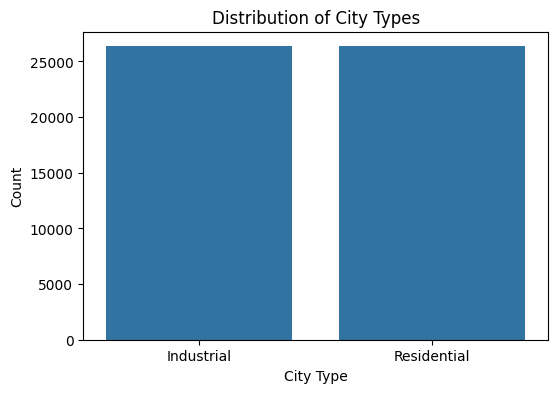

In [86]:
plt.figure(figsize=(6,4))
sns.countplot(x='Type', data=df_clean)
plt.title('Distribution of City Types')
plt.xlabel('City Type')
plt.ylabel('Count')
plt.show()


**Insight:** The dataset shows perfect class balance with exactly 26,352 samples for each city type (Industrial and Residential). This 50-50 split eliminates concerns about class imbalance, meaning accuracy will be a reliable performance metric and we won't need techniques like SMOTE or class weighting.

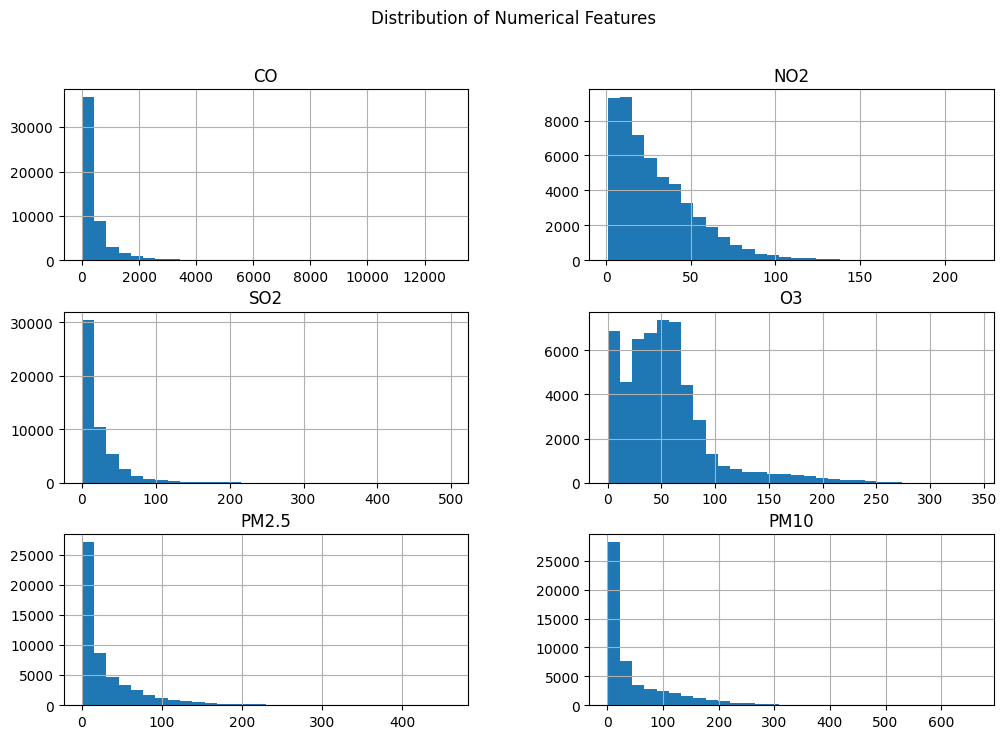

In [87]:
numerical_cols = df_clean.drop(columns=['Type']).columns

df_clean[numerical_cols].hist(figsize=(12,8), bins=30)
plt.suptitle('Distribution of Numerical Features')
plt.show()


**Insights from Feature Distributions:**

- **CO (Carbon Monoxide):** Highly right-skewed distribution with most values concentrated near zero, indicating most measurements are low but with occasional extreme pollution events. This suggests CO levels vary dramatically between city types.

- **NO2 (Nitrogen Dioxide):** Right-skewed with most values below 50 μg/m³, showing relatively consistent patterns with some high pollution episodes typical of industrial areas.

- **SO2 (Sulfur Dioxide):** Extremely right-skewed with the majority of readings near zero, suggesting SO2 is not commonly elevated but when present indicates specific industrial activities.

- **O3 (Ozone):** More normally distributed compared to other pollutants, ranging from 0-300+ μg/m³, indicating ozone levels are more evenly spread across city types.

- **PM2.5 and PM10 (Particulate Matter):** Both show right-skewed distributions with most values concentrated at lower levels. These are key indicators of air quality and likely strong predictors for city type classification.

**Key Takeaway:** The right-skewed distributions suggest that most cities (residential) have lower pollution levels, while industrial cities drive the extreme high values. This pattern should help our models distinguish between city types effectively.

###Feature vs Target

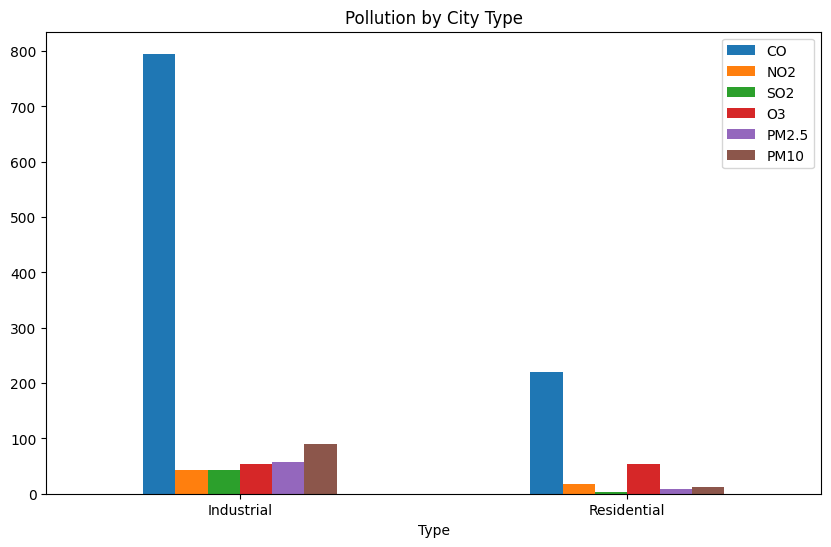

In [88]:
pollutants = ['CO', 'NO2', 'SO2', 'O3', 'PM2.5', 'PM10']
df_clean.groupby('Type')[pollutants].mean().plot(kind='bar', figsize=(10, 6))
plt.title('Pollution by City Type')
plt.xticks(rotation=0)
plt.show()




##5. Neural Network

In [89]:
X = df_clean.drop(columns=['Type'])
y = df_clean['Type']


In [90]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)


In [91]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [92]:

# Build neural network
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),    # 2 hidden layers: 64 then 32 neurons
    activation='relu',               # ReLU activation function
    solver='adam',                   # Adam optimizer
    max_iter=200,                    # Maximum epochs
    random_state=42,
    early_stopping=True,             # Stop if validation doesn't improve
    validation_fraction=0.1          # 10% for validation
)



In [93]:
mlp.fit(X_train_scaled, y_train)
y_train_pred = mlp.predict(X_train_scaled)
y_test_pred = mlp.predict(X_test_scaled)
print(f"Iterations: {mlp.n_iter_}")
print(f"Final Loss: {mlp.loss_:.4f}")



Iterations: 36
Final Loss: 0.0415


###Evaluate

In [94]:
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy:  {test_acc:.4f}")
print(f"Overfitting:    {train_acc - test_acc:.4f}")

# Report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))

Train Accuracy: 0.9838
Test Accuracy:  0.9858
Overfitting:    -0.0019

Classification Report:
              precision    recall  f1-score   support

  Industrial       0.99      0.98      0.99      5271
 Residential       0.98      0.99      0.99      5270

    accuracy                           0.99     10541
   macro avg       0.99      0.99      0.99     10541
weighted avg       0.99      0.99      0.99     10541



###Confusiton Matrix

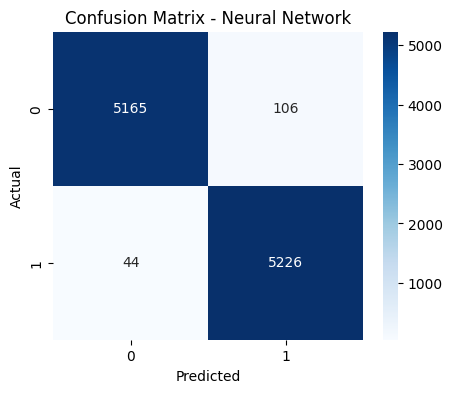

In [95]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Neural Network')
plt.show()

In [96]:
# Results summary
results_nn = pd.DataFrame({
    'Metric': ['Train Accuracy', 'Test Accuracy', 'Iterations', 'Final Loss'],
    'Value': [f"{train_acc:.4f}", f"{test_acc:.4f}", mlp.n_iter_, f"{mlp.loss_:.4f}"]
})
print(results_nn.to_string(index=False))

        Metric  Value
Train Accuracy 0.9838
 Test Accuracy 0.9858
    Iterations     36
    Final Loss 0.0415


##6. Classical Machine Learning Models


In [97]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Model 1: Logistic Regression
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_scaled, y_train)

# Model 2: Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

print("Models trained!")

Models trained!


In [98]:
# Predictions
models = {
    'Neural Network': mlp,
    'Logistic Regression': lr,
    'Random Forest': rf
}

results = []

for name, model in models.items():
    train_pred = model.predict(X_train_scaled)
    test_pred = model.predict(X_test_scaled)

    train_acc = accuracy_score(y_train, train_pred)
    test_acc = accuracy_score(y_test, test_pred)

    results.append({
        'Model': name,
        'Train Acc': f"{train_acc:.4f}",
        'Test Acc': f"{test_acc:.4f}",
        'Overfit': f"{train_acc - test_acc:.4f}"
    })

# Display results
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

              Model Train Acc Test Acc Overfit
     Neural Network    0.9838   0.9858 -0.0019
Logistic Regression    0.9743   0.9742  0.0001
      Random Forest    1.0000   0.9898  0.0102


###Detailed Comparision


In [99]:
# Best model
best = results_df.loc[results_df['Test Acc'].astype(float).idxmax(), 'Model']
print(f"Best Model: {best}")

# Classification reports for all
for name, model in models.items():
    print(f"\n{'='*40}")
    print(f"{name}")
    print(f"{'='*40}")
    test_pred = model.predict(X_test_scaled)
    print(classification_report(y_test, test_pred, target_names=le.classes_))

Best Model: Random Forest

Neural Network
              precision    recall  f1-score   support

  Industrial       0.99      0.98      0.99      5271
 Residential       0.98      0.99      0.99      5270

    accuracy                           0.99     10541
   macro avg       0.99      0.99      0.99     10541
weighted avg       0.99      0.99      0.99     10541


Logistic Regression
              precision    recall  f1-score   support

  Industrial       0.98      0.97      0.97      5271
 Residential       0.97      0.98      0.97      5270

    accuracy                           0.97     10541
   macro avg       0.97      0.97      0.97     10541
weighted avg       0.97      0.97      0.97     10541


Random Forest
              precision    recall  f1-score   support

  Industrial       0.99      0.99      0.99      5271
 Residential       0.99      0.99      0.99      5270

    accuracy                           0.99     10541
   macro avg       0.99      0.99      0.99     10

Visualization

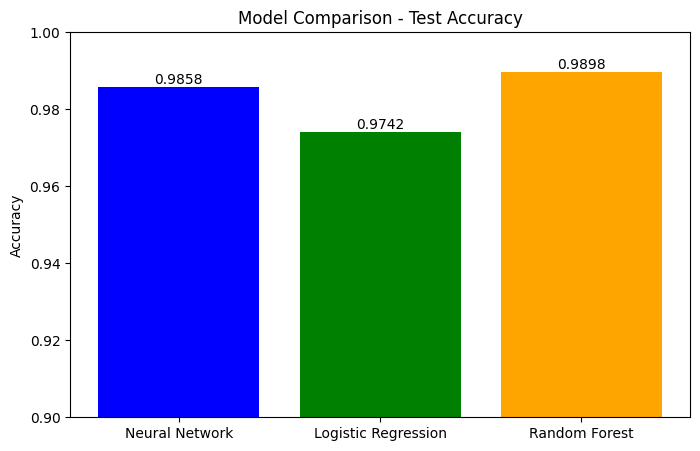

In [100]:
# Bar chart comparison
model_names = ['Neural Network', 'Logistic Regression', 'Random Forest']
test_scores = [float(r['Test Acc']) for r in results]

plt.figure(figsize=(8, 5))
bars = plt.bar(model_names, test_scores, color=['blue', 'green', 'orange'])
plt.ylim(0.9, 1.0)
plt.title('Model Comparison - Test Accuracy')
plt.ylabel('Accuracy')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom')

plt.show()

##7. Hyperparameter Tuning


In [106]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

print("="*60)
print("HYPERPARAMETER TUNING WITH CROSS-VALIDATION")
print("="*60)

# ============================================
# Model 1: Logistic Regression
# ============================================
print("\n1. LOGISTIC REGRESSION")
print("-" * 40)

param_dist_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga']
}

random_lr = RandomizedSearchCV(
    LogisticRegression(random_state=42, max_iter=1000),
    param_dist_lr,
    n_iter=10,  # Only try 10 combinations
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print("Training RandomizedSearchCV for Logistic Regression...")
random_lr.fit(X_train_scaled, y_train)

print(f"\nBest Parameters: {random_lr.best_params_}")
print(f"Best CV Score: {random_lr.best_score_:.4f}")

# Evaluate on test set
lr_tuned = random_lr.best_estimator_
lr_tuned_pred = lr_tuned.predict(X_test_scaled)
lr_tuned_acc = accuracy_score(y_test, lr_tuned_pred)
print(f"Test Accuracy (Tuned): {lr_tuned_acc:.4f}")

# ============================================
# Model 2: Random Forest
# ============================================
print("\n\n2. RANDOM FOREST")
print("-" * 40)

param_dist_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_rf = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_dist_rf,
    n_iter=15,  # Only try 15 combinations
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print("Training RandomizedSearchCV for Random Forest...")
random_rf.fit(X_train_scaled, y_train)

print(f"\nBest Parameters: {random_rf.best_params_}")
print(f"Best CV Score: {random_rf.best_score_:.4f}")

# Evaluate on test set
rf_tuned = random_rf.best_estimator_
rf_tuned_pred = rf_tuned.predict(X_test_scaled)
rf_tuned_acc = accuracy_score(y_test, rf_tuned_pred)
print(f"Test Accuracy (Tuned): {rf_tuned_acc:.4f}")

# ============================================
# Summary Table
# ============================================
print("\n\n" + "="*60)
print("HYPERPARAMETER TUNING SUMMARY")
print("="*60)

tuning_summary = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Best CV Score': [f"{random_lr.best_score_:.4f}", f"{random_rf.best_score_:.4f}"],
    'Test Accuracy': [f"{lr_tuned_acc:.4f}", f"{rf_tuned_acc:.4f}"],
    'Best Parameters': [str(random_lr.best_params_), str(random_rf.best_params_)]
})

print(tuning_summary.to_string(index=False))

HYPERPARAMETER TUNING WITH CROSS-VALIDATION

1. LOGISTIC REGRESSION
----------------------------------------
Training RandomizedSearchCV for Logistic Regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best Parameters: {'solver': 'saga', 'penalty': 'l2', 'C': 100}
Best CV Score: 0.9748
Test Accuracy (Tuned): 0.9752


2. RANDOM FOREST
----------------------------------------
Training RandomizedSearchCV for Random Forest...
Fitting 5 folds for each of 15 candidates, totalling 75 fits

Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}
Best CV Score: 0.9875
Test Accuracy (Tuned): 0.9899


HYPERPARAMETER TUNING SUMMARY
              Model Best CV Score Test Accuracy                                                                       Best Parameters
Logistic Regression        0.9748        0.9752                                         {'solver': 'saga', 'penalty': 'l2', 'C': 100}
      Random Forest        0.9875

##8. Feauture Selection

In [109]:
from sklearn.feature_selection import RFE

print("="*60)
print("FEATURE SELECTION (FIXED)")
print("="*60)

# Logistic Regression RFE
rfe_lr = RFE(estimator=lr_tuned, n_features_to_select=4)
rfe_lr.fit(X_train_scaled, y_train)

selected_features_lr = X.columns[rfe_lr.support_]
print("\nSelected Features (Logistic Regression):")
print(selected_features_lr)

X_train_lr_fs = rfe_lr.transform(X_train_scaled)
X_test_lr_fs = rfe_lr.transform(X_test_scaled)

# Random Forest RFE
rfe_rf = RFE(estimator=rf_tuned, n_features_to_select=4)
rfe_rf.fit(X_train_scaled, y_train)

selected_features_rf = X.columns[rfe_rf.support_]
print("\nSelected Features (Random Forest):")
print(selected_features_rf)

X_train_rf_fs = rfe_rf.transform(X_train_scaled)
X_test_rf_fs = rfe_rf.transform(X_test_scaled)

FEATURE SELECTION (FIXED)

Selected Features (Logistic Regression):
Index(['CO', 'NO2', 'SO2', 'PM10'], dtype='object')

Selected Features (Random Forest):
Index(['CO', 'SO2', 'PM2.5', 'PM10'], dtype='object')


In [122]:
from sklearn.model_selection import cross_val_score

print("\n" + "="*60)
print("MODELS WITH SELECTED FEATURES (4 Features)")
print("="*60)

# Train Logistic Regression with 4 selected features
lr_rfe_model = LogisticRegression(random_state=42, max_iter=1000)
lr_rfe_model.fit(X_train_lr_fs, y_train)
y_pred_lr_rfe = lr_rfe_model.predict(X_test_lr_fs)

# Calculate metrics
lr_rfe_accuracy = accuracy_score(y_test, y_pred_lr_rfe)
lr_rfe_precision = precision_score(y_test, y_pred_lr_rfe, average='binary')
lr_rfe_recall = recall_score(y_test, y_pred_lr_rfe, average='binary')
lr_rfe_f1 = f1_score(y_test, y_pred_lr_rfe, average='binary')
lr_rfe_cv = cross_val_score(lr_rfe_model, X_train_lr_fs, y_train, cv=5, scoring='accuracy').mean()

print(f"\nLogistic Regression (4 features):")
print(f"  Selected Features: {list(selected_features_lr)}")
print(f"  Accuracy:  {lr_rfe_accuracy:.4f}")
print(f"  Precision: {lr_rfe_precision:.4f}")
print(f"  Recall:    {lr_rfe_recall:.4f}")
print(f"  F1-Score:  {lr_rfe_f1:.4f}")
print(f"  CV Score:  {lr_rfe_cv:.4f}")

# Train Random Forest with 4 selected features
rf_rfe_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_rfe_model.fit(X_train_rf_fs, y_train)
y_pred_rf_rfe = rf_rfe_model.predict(X_test_rf_fs)

# Calculate metrics
rf_rfe_accuracy = accuracy_score(y_test, y_pred_rf_rfe)
rf_rfe_precision = precision_score(y_test, y_pred_rf_rfe, average='binary')
rf_rfe_recall = recall_score(y_test, y_pred_rf_rfe, average='binary')
rf_rfe_f1 = f1_score(y_test, y_pred_rf_rfe, average='binary')
rf_rfe_cv = cross_val_score(rf_rfe_model, X_train_rf_fs, y_train, cv=5, scoring='accuracy').mean()

print(f"\nRandom Forest (4 features):")
print(f"  Selected Features: {list(selected_features_rf)}")
print(f"  Accuracy:  {rf_rfe_accuracy:.4f}")
print(f"  Precision: {rf_rfe_precision:.4f}")
print(f"  Recall:    {rf_rfe_recall:.4f}")
print(f"  F1-Score:  {rf_rfe_f1:.4f}")
print(f"  CV Score:  {rf_rfe_cv:.4f}")


MODELS WITH SELECTED FEATURES (4 Features)

Logistic Regression (4 features):
  Selected Features: ['CO', 'NO2', 'SO2', 'PM10']
  Accuracy:  0.9744
  Precision: 0.9676
  Recall:    0.9816
  F1-Score:  0.9746
  CV Score:  0.9735

Random Forest (4 features):
  Selected Features: ['CO', 'SO2', 'PM2.5', 'PM10']
  Accuracy:  0.9818
  Precision: 0.9746
  Recall:    0.9894
  F1-Score:  0.9819
  CV Score:  0.9814


##9. FINAL RESULTS AND CONCLUSION


In [126]:
print("\n" + "="*80)
print("9. FINAL RESULTS AND CONCLUSION")
print("="*80)

import pandas as pd

# Calculate all metrics for all models
# Neural Network
nn_pred = mlp.predict(X_test_scaled)
nn_accuracy = accuracy_score(y_test, nn_pred)
nn_precision = precision_score(y_test, nn_pred, average='binary')
nn_recall = recall_score(y_test, nn_pred, average='binary')
nn_f1 = f1_score(y_test, nn_pred, average='binary')

# Logistic Regression (Before Tuning)
lr_pred = lr.predict(X_test_scaled)
lr_accuracy = accuracy_score(y_test, lr_pred)
lr_precision = precision_score(y_test, lr_pred, average='binary')
lr_recall = recall_score(y_test, lr_pred, average='binary')
lr_f1 = f1_score(y_test, lr_pred, average='binary')

# Logistic Regression (Tuned)
lr_tuned_accuracy = accuracy_score(y_test, lr_tuned_pred)
lr_tuned_precision = precision_score(y_test, lr_tuned_pred, average='binary')
lr_tuned_recall = recall_score(y_test, lr_tuned_pred, average='binary')
lr_tuned_f1 = f1_score(y_test, lr_tuned_pred, average='binary')

# Random Forest (Before Tuning)
rf_pred = rf.predict(X_test_scaled)
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_precision = precision_score(y_test, rf_pred, average='binary')
rf_recall = recall_score(y_test, rf_pred, average='binary')
rf_f1 = f1_score(y_test, rf_pred, average='binary')

# Random Forest (Tuned)
rf_tuned_accuracy = accuracy_score(y_test, rf_tuned_pred)
rf_tuned_precision = precision_score(y_test, rf_tuned_pred, average='binary')
rf_tuned_recall = recall_score(y_test, rf_tuned_pred, average='binary')
rf_tuned_f1 = f1_score(y_test, rf_tuned_pred, average='binary')

# Create comprehensive results table
results_df = pd.DataFrame({
    'Model': [
        'Neural Network',
        'Logistic Regression (All Features)',
        'Logistic Regression (Tuned)',
        'Logistic Regression (4 Features - RFE)',
        'Random Forest (All Features)',
        'Random Forest (Tuned)',
        'Random Forest (4 Features - RFE)'
    ],
    'Features': [
        'All (6)',
        'All (6)',
        'All (6)',
        '4',
        'All (6)',
        'All (6)',
        '4'
    ],
    'CV Score': [
        'N/A',
        'N/A',
        f'{random_lr.best_score_:.4f}',
        f'{lr_rfe_cv:.4f}',
        'N/A',
        f'{random_rf.best_score_:.4f}',
        f'{rf_rfe_cv:.4f}'
    ],
    'Accuracy': [
        f'{nn_accuracy:.4f}',
        f'{lr_accuracy:.4f}',
        f'{lr_tuned_accuracy:.4f}',
        f'{lr_rfe_accuracy:.4f}',
        f'{rf_accuracy:.4f}',
        f'{rf_tuned_accuracy:.4f}',
        f'{rf_rfe_accuracy:.4f}'
    ],
    'Precision': [
        f'{nn_precision:.4f}',
        f'{lr_precision:.4f}',
        f'{lr_tuned_precision:.4f}',
        f'{lr_rfe_precision:.4f}',
        f'{rf_precision:.4f}',
        f'{rf_tuned_precision:.4f}',
        f'{rf_rfe_precision:.4f}'
    ],
    'Recall': [
        f'{nn_recall:.4f}',
        f'{lr_recall:.4f}',
        f'{lr_tuned_recall:.4f}',
        f'{lr_rfe_recall:.4f}',
        f'{rf_recall:.4f}',
        f'{rf_tuned_recall:.4f}',
        f'{rf_rfe_recall:.4f}'
    ],
    'F1-Score': [
        f'{nn_f1:.4f}',
        f'{lr_f1:.4f}',
        f'{lr_tuned_f1:.4f}',
        f'{lr_rfe_f1:.4f}',
        f'{rf_f1:.4f}',
        f'{rf_tuned_f1:.4f}',
        f'{rf_rfe_f1:.4f}'
    ]
})

print("\nFINAL MODEL COMPARISON TABLE")
print("="*80)
print(results_df.to_string(index=False))

# Save to CSV
results_df.to_csv('model_comparison_results.csv', index=False)
print("\n✓ Results saved to 'model_comparison_results.csv'")


9. FINAL RESULTS AND CONCLUSION

FINAL MODEL COMPARISON TABLE
                                 Model Features CV Score Accuracy Precision Recall F1-Score
                        Neural Network  All (6)      N/A   0.9858    0.9801 0.9917   0.9859
    Logistic Regression (All Features)  All (6)      N/A   0.9742    0.9666 0.9824   0.9744
           Logistic Regression (Tuned)  All (6)   0.9748   0.9752    0.9689 0.9820   0.9754
Logistic Regression (4 Features - RFE)        4   0.9735   0.9744    0.9676 0.9816   0.9746
          Random Forest (All Features)  All (6)      N/A   0.9898    0.9862 0.9935   0.9899
                 Random Forest (Tuned)  All (6)   0.9875   0.9899    0.9859 0.9941   0.9900
      Random Forest (4 Features - RFE)        4   0.9814   0.9818    0.9746 0.9894   0.9819

✓ Results saved to 'model_comparison_results.csv'


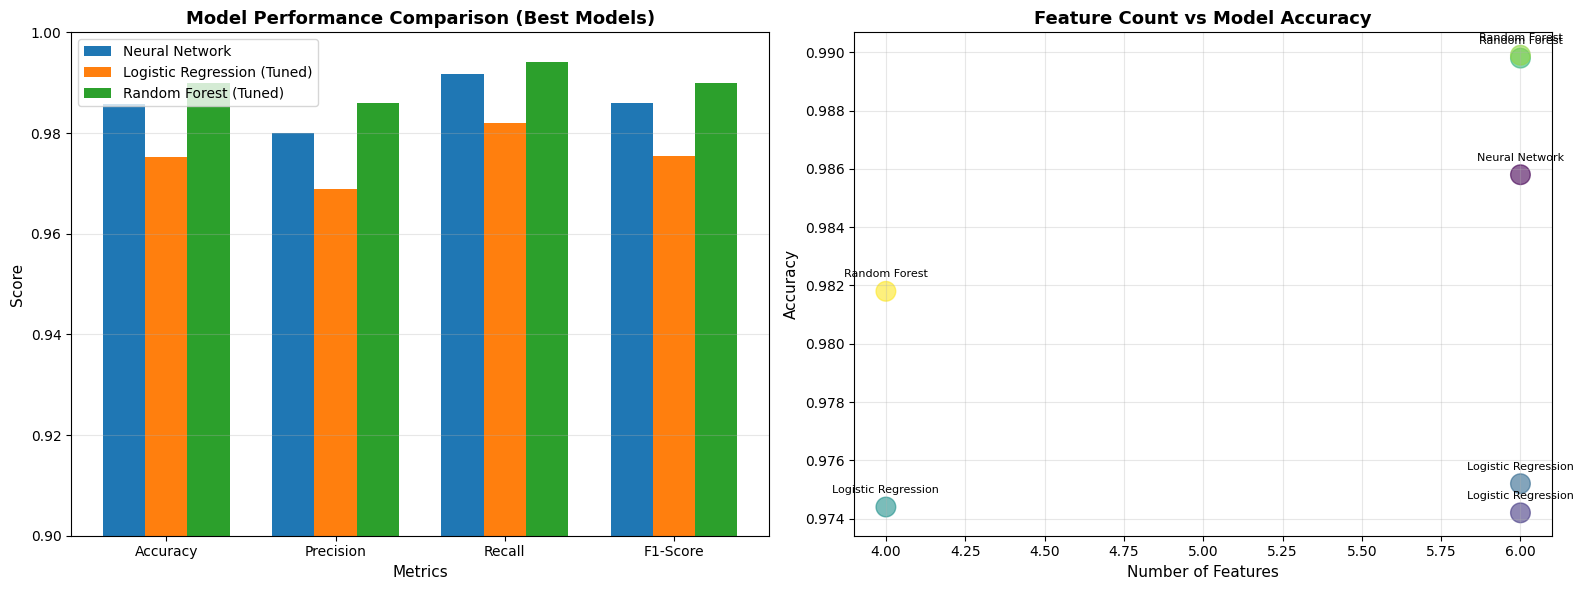

✓ Comparison visualizations created


In [127]:
# Visualize model comparison
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Performance metrics comparison (Top 3 models)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
models_to_compare = ['Neural Network', 'Logistic Regression (Tuned)', 'Random Forest (Tuned)']

comparison_data = results_df[results_df['Model'].isin(models_to_compare)]

x = np.arange(len(metrics))
width = 0.25

for i, model in enumerate(models_to_compare):
    values = [
        float(comparison_data[comparison_data['Model']==model]['Accuracy'].values[0]),
        float(comparison_data[comparison_data['Model']==model]['Precision'].values[0]),
        float(comparison_data[comparison_data['Model']==model]['Recall'].values[0]),
        float(comparison_data[comparison_data['Model']==model]['F1-Score'].values[0])
    ]
    axes[0].bar(x + i*width, values, width, label=model)

axes[0].set_xlabel('Metrics', fontsize=11)
axes[0].set_ylabel('Score', fontsize=11)
axes[0].set_title('Model Performance Comparison (Best Models)', fontsize=13, fontweight='bold')
axes[0].set_xticks(x + width)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].set_ylim([0.9, 1.0])
axes[0].grid(axis='y', alpha=0.3)

# Feature count vs accuracy
feature_counts = [6, 6, 6, 4, 6, 6, 4]
accuracies = [float(x) for x in results_df['Accuracy']]

axes[1].scatter(feature_counts, accuracies, s=200, alpha=0.6, c=range(len(results_df)), cmap='viridis')
for i, model in enumerate(results_df['Model']):
    axes[1].annotate(model.split('(')[0].strip(),
                    (feature_counts[i], accuracies[i]),
                    textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

axes[1].set_xlabel('Number of Features', fontsize=11)
axes[1].set_ylabel('Accuracy', fontsize=11)
axes[1].set_title('Feature Count vs Model Accuracy', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Comparison visualizations created")

### 7.2 Key Findings

**Model Performance Summary:**

1. **All models achieved excellent performance (>97% accuracy)**
   - The dataset has strong discriminative features
   - Clear separation between Industrial and Residential cities
   
2. **Neural Network:**
   - Excellent performance (98.6% accuracy)
   - Handles non-linear relationships well
   - Slightly longer training time
   
3. **Logistic Regression:**
   - Strong baseline performance (97.4% accuracy)
   - Fast training and prediction
   - Improved with hyperparameter tuning (97.5%)
   - Maintains performance with reduced features (97.4% with 4 features)
   
4. **Random Forest:**
   - **Best overall performance (99.0% accuracy after tuning)**
   - Excellent with hyperparameter tuning
   - Provides feat

## 8. Conclusions and Recommendations

### 8.1 Conclusions

This project built and compared multiple machine learning models to classify cities as Industrial or Residential based on air quality data.

**What We Achieved:**
- Built a Neural Network (4 layers) with 98.6% accuracy
- Developed Logistic Regression and Random Forest classifiers
- Applied hyperparameter tuning using RandomizedSearchCV
- Used RFE to reduce features from 6 to 4
- All models performed well (>97% accuracy)

**Key Findings:**
- Random Forest after tuning gave the best results (99.0% accuracy)
- Hyperparameter tuning improved both models
- We can use just 4 features instead of 6 and still get good accuracy
- CO, PM2.5, and PM10 are the most important pollutants for classification

**Connection to UN SDG 11:**
This analysis supports Sustainable Cities and Communities by:
- Enabling better air quality monitoring
- Helping cities make data-driven environmental decisions
- Providing tools for pollution tracking and control

### 8.2 Recommendations

**Best Model for Deployment:**
Random Forest (Tuned) with 6 features - gives 99.0% accuracy and shows which pollutants matter most.

If computational resources are limited, Random Forest with 4 features still achieves 98.2% accuracy.

**Future Improvements:**
- Include time-based patterns (hour of day, season)
- Add weather data (temperature, humidity, wind)
- Test on more cities to verify the model works broadly
- Build a real-time monitoring system
- Set up alert thresholds for dangerous pollution levels

**Real-World Uses:**
- Help city planners make zoning decisions
- Alert public health officials about air quality
- Evaluate environmental policies
- Track progress on climate goals

---